In [4]:
pip install numpy==1.26.4 torch transformers==4.48.2 scikit-learn accelerate==0.26.0



  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [5]:
pip install matplotlib tqdm pandas

Note: you may need to restart the kernel to use updated packages.



📊 Distribusi file per kelas:
Kelas  Jumlah File
    L         5600
    N         5600
    Q         5600
    R         5600
    V         5600


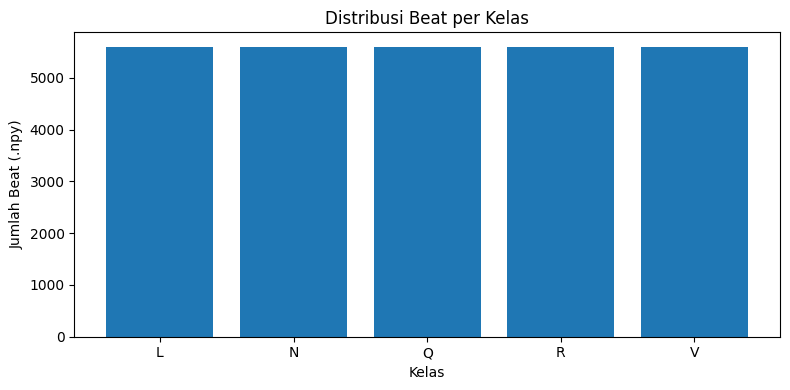

In [1]:
import os, glob
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

# ═══ GANTI PATH DI BAWAH INI ═══
DATA_DIR = r"/workspace/SPLIT_BEATS_NPY/train"   # folder utama data train (.npy)

# ── Hitung file per kelas ────────────────────────────────────────
counts = OrderedDict()
for cls in sorted(os.listdir(DATA_DIR)):
    cls_path = os.path.join(DATA_DIR, cls)
    if not os.path.isdir(cls_path):
        continue
    n_files = len(glob.glob(os.path.join(cls_path, "*.npy")))
    counts[cls] = n_files

# ── Tampilkan tabel distribusi ───────────────────────────────────
df = pd.DataFrame(
    {"Kelas": list(counts.keys()), "Jumlah File": list(counts.values())}
)
print("\n📊 Distribusi file per kelas:")
print(df.to_string(index=False))

# ── (Opsional) plot bar chart ────────────────────────────────────
plt.figure(figsize=(8,4))
plt.bar(df["Kelas"], df["Jumlah File"])
plt.xlabel("Kelas")
plt.ylabel("Jumlah Beat (.npy)")
plt.title("Distribusi Beat per Kelas")
plt.tight_layout()
plt.show()

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [34]:
import os, glob, random, numpy as np, torch, pandas as pd, matplotlib.pyplot as plt, gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from transformers import (BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments, set_seed)

# ═════════════ KONFIGURASI ══════════════════════════════════════════════
DATA_DIR   = "/workspace/SPLIT_BEATS_NPY/train"
LABEL_MAP  = {'N':0,'L':1,'R':2,'V':3,'Q':4}
MODEL_NAME = "bert-base-uncased"
SEED       = 42
N_SPLITS   = 5
EPOCHS     = 20
BATCH_SIZE = 32
MAX_LEN    = 512
OUTPUT_BASE= "/workspace/HASIL_BERT/HASIL_5"   # semua hasil per‑fold disini

set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cls_names = list(LABEL_MAP.keys())

# ═════════════ UTIL ═════════════════════════════════════════════════════

def signal_to_text(sig: np.ndarray) -> str:
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    return " ".join(map(str, norm.tolist()))

# ═════════════ LOAD DATA ════════════════════════════════════════════════
files, labels = [], []
for cls, idx in LABEL_MAP.items():
    for f in glob.glob(os.path.join(DATA_DIR, cls, "*.npy")):
        files.append(f); labels.append(idx)
files, labels = np.array(files), np.array(labels)
print(f"Loaded {len(files)} samples across {len(LABEL_MAP)} classes")

# ═════════════ TOKENISASI SEMUA DATA ════════════════════════════════════
print("Tokenizing all samples …")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
all_ids, all_mask = [], []
for f in files:
    txt = signal_to_text(np.load(f))
    enc = tokenizer(txt, padding="max_length", truncation=True,
                    max_length=MAX_LEN, return_tensors="pt")
    all_ids.append(enc["input_ids"].squeeze(0))
    all_mask.append(enc["attention_mask"].squeeze(0))
all_ids  = torch.stack(all_ids)
all_mask = torch.stack(all_mask)
labels_t = torch.tensor(labels)

# ═════════════ K‑FOLD TRAINING ═════════════════════════════════════════=
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_metrics, fold_predictions = [], {}

for fold,(tr,va) in enumerate(skf.split(all_ids, labels),1):
    print(f"\n════ FOLD {fold}/{N_SPLITS} ════")
    gc.collect(); torch.cuda.empty_cache()

    train_ds = torch.utils.data.TensorDataset(all_ids[tr], all_mask[tr], labels_t[tr])
    val_ds   = torch.utils.data.TensorDataset(all_ids[va], all_mask[va], labels_t[va])

    def collate(batch):
        ids, msk, lbl = map(torch.stack, zip(*batch))
        return {"input_ids": ids, "attention_mask": msk, "labels": lbl}

    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(LABEL_MAP)).to(DEVICE)

    out_dir = os.path.join(OUTPUT_BASE, f"fold{fold}")
    os.makedirs(out_dir, exist_ok=True)

    args = TrainingArguments(
        output_dir            = out_dir,
        per_device_train_batch_size = BATCH_SIZE,
        per_device_eval_batch_size  = BATCH_SIZE,
        num_train_epochs      = EPOCHS,
        evaluation_strategy   = "epoch",
        save_strategy         = "epoch",     # ⬅️ simpan model tiap epoch
        save_total_limit      = 1,
        load_best_model_at_end= True,
        metric_for_best_model = "eval_loss",
        seed                 = SEED,
        logging_strategy     = "epoch",
        report_to            = []
    )

    trainer = Trainer(model=model, args=args,
                      train_dataset=train_ds,
                      eval_dataset=val_ds,
                      data_collator=collate)

    trainer.train()

    # simpan best model & tokenizer (jaga-jaga)
    trainer.save_model(out_dir)      # menyimpan pytorch_model.bin & config.json
    tokenizer.save_pretrained(out_dir)

    # ═════════════ EVALUASI ═════════════════════════════════════════════
    preds = torch.argmax(torch.from_numpy(trainer.predict(val_ds).predictions), dim=1).numpy()
    y_true = labels_t[va].cpu().numpy()
    fold_predictions[fold] = {"y_true": y_true, "y_pred": preds}

    cm = confusion_matrix(y_true, preds, labels=list(range(len(cls_names))))

    per_cls = {}
    for i,cls in enumerate(cls_names):
        TP = cm[i,i]; FN = cm[i].sum()-TP; FP = cm[:,i].sum()-TP; TN = cm.sum()-(TP+FN+FP)
        acc  = (TP+TN)/cm.sum(); rec = TP/(TP+FN+1e-8); spec = TN/(TN+FP+1e-8); f1 = f1_score(y_true, preds, labels=[i], average='macro')
        per_cls[cls] = {'ACC':acc,'F1':f1,'REC':rec,'SPEC':spec}
    fold_metrics.append(per_cls)

    # simpan confusion matrix
    plt.figure(figsize=(7,6))
    plt.imshow(cm, cmap='Blues'); plt.title(f"Confusion Fold {fold}")
    plt.xticks(range(len(cls_names)), cls_names); plt.yticks(range(len(cls_names)), cls_names)
    for r in range(len(cm)):
        for c in range(len(cm)):
            plt.text(c, r, cm[r,c], ha='center', va='center', color='black')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "confusion_fold.png")); plt.close()

    # print tabel metrik
    print(pd.DataFrame(per_cls).T.round(3))

    # kosongkan memori
    model.cpu(); del trainer; torch.cuda.empty_cache(); gc.collect()

# ═════════════ RINGKASAN AKHIR ══════════════════════════════════════════
summary = {c:{m:[] for m in ['ACC','F1','REC','SPEC']} for c in cls_names}
for fm in fold_metrics:
    for c in cls_names:
        for m in summary[c]:
            summary[c][m].append(fm[c][m])

df_summary = pd.DataFrame({c:{m:f"{np.mean(v):.3f}±{np.std(v):.3f}" for m,v in summary[c].items()} for c in cls_names}).T
print("\n════ MEAN±STD METRICS ════\n", df_summary)

df_summary.to_csv(os.path.join(OUTPUT_BASE, "final_summary.csv"))


Loaded 28000 samples across 5 classes
Tokenizing all samples …

════ FOLD 1/5 ════


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.373100,0.158208
2,0.119000,0.114419
3,0.084500,0.121262
4,0.061400,0.108887
5,0.048200,0.077716
6,0.034800,0.088786
7,0.025600,0.092626
8,0.024800,0.096708
9,0.020100,0.109399
10,0.013500,0.102393


     ACC     F1    REC   SPEC
N  0.988  0.969  0.962  0.994
L  0.994  0.986  0.982  0.997
R  0.997  0.993  0.998  0.997
V  0.988  0.970  0.981  0.990
Q  0.998  0.994  0.988  1.000

════ FOLD 2/5 ════


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.380000,0.117349
2,0.117900,0.166446
3,0.081500,0.089371
4,0.066200,0.068708
5,0.047500,0.058401
6,0.037000,0.069460
7,0.028500,0.070006
8,0.026900,0.076681
9,0.020000,0.060158
10,0.016600,0.085657


     ACC     F1    REC   SPEC
N  0.996  0.989  0.987  0.998
L  0.998  0.994  0.994  0.998
R  0.998  0.996  0.996  0.999
V  0.994  0.986  0.988  0.996
Q  0.998  0.996  0.996  0.999

════ FOLD 3/5 ════


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.451800,0.291807
2,0.129600,0.136920
3,0.093200,0.119806
4,0.067800,0.077794
5,0.051500,0.077270
6,0.043600,0.076804
7,0.029600,0.104580
8,0.026800,0.088432
9,0.019700,0.085150
10,0.012600,0.080287


     ACC     F1    REC   SPEC
N  0.990  0.975  0.973  0.994
L  0.995  0.988  0.986  0.998
R  0.997  0.992  0.991  0.998
V  0.989  0.973  0.981  0.991
Q  0.996  0.990  0.987  0.998

════ FOLD 4/5 ════


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.470100,0.209857
2,0.157600,0.150282
3,0.107900,0.151978
4,0.085000,0.090102
5,0.064800,0.105156
6,0.050600,0.075402
7,0.034800,0.091769
8,0.029000,0.107881
9,0.023800,0.087137
10,0.017600,0.113653


     ACC     F1    REC   SPEC
N  0.992  0.979  0.979  0.995
L  0.995  0.987  0.979  0.999
R  0.995  0.988  0.995  0.995
V  0.989  0.974  0.975  0.993
Q  0.995  0.988  0.989  0.997

════ FOLD 5/5 ════


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.595700,0.265342
2,0.192000,0.132383
3,0.129600,0.130108
4,0.102100,0.112193
5,0.083800,0.101353
6,0.074500,0.126879
7,0.059600,0.087028
8,0.046800,0.090367
9,0.039900,0.082622
10,0.033200,0.094863


     ACC     F1    REC   SPEC
N  0.993  0.982  0.987  0.994
L  0.997  0.992  0.988  0.999
R  0.998  0.995  0.996  0.999
V  0.992  0.980  0.980  0.995
Q  0.998  0.994  0.991  0.999

════ MEAN±STD METRICS ════
            ACC           F1          REC         SPEC
N  0.992±0.003  0.979±0.007  0.978±0.010  0.995±0.001
L  0.996±0.001  0.989±0.003  0.986±0.005  0.998±0.001
R  0.997±0.001  0.993±0.003  0.995±0.002  0.998±0.001
V  0.991±0.002  0.977±0.006  0.981±0.004  0.993±0.002
Q  0.997±0.001  0.992±0.003  0.990±0.003  0.999±0.001


In [26]:
# Setelah trainer.train() tiap fold dan sebelum model dihapus:
model.save_pretrained(output_dir)          # simpan pytorch_model.bin + config.json
tokenizer.save_pretrained(output_dir)      # simpan tokenizer

('/workspace/HASIL/HASIL_3/fold5/tokenizer_config.json',
 '/workspace/HASIL/HASIL_3/fold5/special_tokens_map.json',
 '/workspace/HASIL/HASIL_3/fold5/vocab.txt',
 '/workspace/HASIL/HASIL_3/fold5/added_tokens.json')

In [36]:
import pandas as pd

# Gabungkan semua hasil fold ke dalam satu DataFrame                                                   
rows = []
for i, fold_data in enumerate(fold_metrics, 1):
    for cls, metrics in fold_data.items():
        row = {
            'fold': i,
            'kelas': cls,
            'akurasi': round(metrics['ACC'], 4),
            'f1': round(metrics['F1'], 4),
            'recall': round(metrics['REC'], 4),
            'spesifisitas': round(metrics['SPEC'], 4)
        }
        rows.append(row)

# Buat DataFrame
df_all_folds = pd.DataFrame(rows)

# Simpan ke file CSV
df_all_folds.to_csv("/workspace/HASIL_BERT/HASIL_5/final_summary.csv", index=False)
print(df_all_folds)


    fold kelas  akurasi      f1  recall  spesifisitas
0      1     N   0.9877  0.9690  0.9616        0.9942
1      1     L   0.9943  0.9857  0.9821        0.9973
2      1     R   0.9971  0.9929  0.9982        0.9969
3      1     V   0.9880  0.9704  0.9812        0.9897
4      1     Q   0.9975  0.9937  0.9884        0.9998
5      2     N   0.9957  0.9893  0.9875        0.9978
6      2     L   0.9975  0.9938  0.9937        0.9984
7      2     R   0.9984  0.9960  0.9955        0.9991
8      2     V   0.9943  0.9858  0.9884        0.9958
9      2     Q   0.9984  0.9960  0.9955        0.9991
10     3     N   0.9902  0.9754  0.9732        0.9944
11     3     L   0.9952  0.9879  0.9857        0.9975
12     3     R   0.9970  0.9924  0.9911        0.9984
13     3     V   0.9891  0.9730  0.9812        0.9911
14     3     Q   0.9961  0.9902  0.9875        0.9982
15     4     N   0.9918  0.9794  0.9786        0.9951
16     4     L   0.9948  0.9869  0.9786        0.9989
17     4     R   0.9952  0.9

In [37]:
# Hitung rata-rata akurasi per fold
avg_acc_per_fold = df_all_folds.groupby("fold")["akurasi"].mean()

# Cari fold dengan rata-rata akurasi tertinggi
best_fold = avg_acc_per_fold.idxmax()
best_acc = avg_acc_per_fold.max()

print(f"Fold terbaik adalah FOLD {best_fold} dengan rata-rata akurasi: {best_acc:.4f}")

# Tampilkan seluruh metrik pada fold terbaik
best_fold_df = df_all_folds[df_all_folds["fold"] == best_fold]
print("\nDetail metrik pada Fold terbaik:")
print(best_fold_df)

Fold terbaik adalah FOLD 2 dengan rata-rata akurasi: 0.9969

Detail metrik pada Fold terbaik:
   fold kelas  akurasi      f1  recall  spesifisitas
5     2     N   0.9957  0.9893  0.9875        0.9978
6     2     L   0.9975  0.9938  0.9937        0.9984
7     2     R   0.9984  0.9960  0.9955        0.9991
8     2     V   0.9943  0.9858  0.9884        0.9958
9     2     Q   0.9984  0.9960  0.9955        0.9991


In [9]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Menampilkan confusion matrix untuk Fold 2


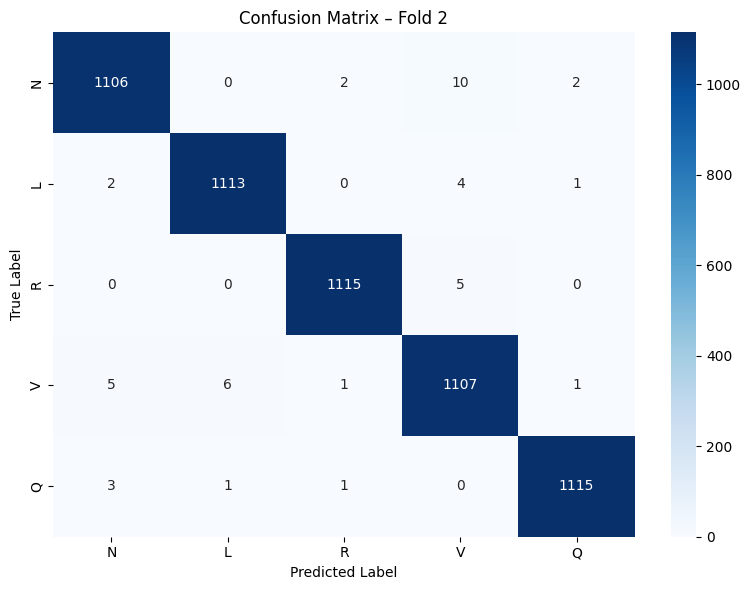

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ambil prediksi dan label asli untuk fold terbaik (asumsi kamu simpan sebelumnya)
# Misalnya disimpan dalam dict bernama fold_predictions
# Format: fold_predictions[fold] = {"y_true": [...], "y_pred": [...]}
# Jika belum punya, kamu perlu menyimpan y_true dan y_pred per fold saat training

# Cek fold terbaik
best_fold = df_all_folds.groupby("fold")["akurasi"].mean().idxmax()
print(f"Menampilkan confusion matrix untuk Fold {best_fold}")

# Ambil data y_true dan y_pred dari fold terbaik
y_true = fold_predictions[best_fold]["y_true"]
y_pred = fold_predictions[best_fold]["y_pred"]
class_names = ["N", "L", "R", "V", "Q"]

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix – Fold {best_fold}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [32]:
import os, torch, numpy as np, glob
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ════ KONFIGURASI =====================================================================
TEST_DIR    = "/workspace/SPLIT_BEATS_NPY/test"
MODEL_DIR   = "/workspace/HASIL_BERT/HASIL_4"
LABEL_MAP   = {'N': 0, 'L': 1, 'R': 2, 'V': 3, 'Q': 4}
MODEL_NAME  = "bert-base-uncased"
MAX_LEN     = 512
BATCH_SIZE  = 32
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cls_names   = list(LABEL_MAP.keys())

# ════ TOKENIZER =======================================================================
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def signal_to_text(sig: np.ndarray) -> str:
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    return " ".join(map(str, norm.tolist()))

# ════ LOAD TEST DATA ==================================================================
test_files, test_labels = [], []
for cls, idx in LABEL_MAP.items():
    for f in glob.glob(os.path.join(TEST_DIR, cls, "*.npy")):
        test_files.append(f)
        test_labels.append(idx)
test_labels = np.array(test_labels)

texts = [signal_to_text(np.load(f)) for f in test_files]
encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors='pt')
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']

# ════ UJI SETIAP FOLD =================================================================
results_per_fold = []

for fold in range(1, 6):
    print(f"\n=== Evaluating Fold {fold} Model ===")

    # Load model
    model_path = os.path.join(MODEL_DIR, f"fold{fold}")
    model = BertForSequenceClassification.from_pretrained(model_path).to(DEVICE)
    model.eval()

    # Predict in batches
    preds = []
    with torch.no_grad():
        for i in range(0, len(input_ids), BATCH_SIZE):
            ids = input_ids[i:i+BATCH_SIZE].to(DEVICE)
            att = attention_mask[i:i+BATCH_SIZE].to(DEVICE)
            outputs = model(ids, attention_mask=att)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    preds = np.array(preds)
    report = classification_report(test_labels, preds, target_names=cls_names, output_dict=True)
    df = pd.DataFrame(report).T
    df.to_csv(os.path.join(model_path, f"test_report_fold{fold}.csv"))
    results_per_fold.append(df)

    # Confusion matrix
    cm = confusion_matrix(test_labels, preds)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cls_names, yticklabels=cls_names)
    plt.title(f"Confusion Matrix Fold {fold} (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(model_path, f"conf_matrix_test_fold{fold}.png"))
    plt.close()

    print(df[['precision', 'recall', 'f1-score']].iloc[:-1])  # Print class-wise results

print("\n✅ Selesai evaluasi semua fold terhadap data test.")



=== Evaluating Fold 1 Model ===
           precision    recall  f1-score
N           0.980132  0.951429  0.965567
L           0.970423  0.984286  0.977305
R           0.988547  0.986429  0.987487
V           0.941917  0.961429  0.951573
Q           0.988530  0.985000  0.986762
accuracy    0.973714  0.973714  0.973714
macro avg   0.973910  0.973714  0.973739

=== Evaluating Fold 2 Model ===
           precision    recall  f1-score
N           0.966138  0.957857  0.961980
L           0.967156  0.988571  0.977746
R           0.990007  0.990714  0.990361
V           0.959971  0.959286  0.959628
Q           0.989138  0.975714  0.982380
accuracy    0.974429  0.974429  0.974429
macro avg   0.974482  0.974429  0.974419

=== Evaluating Fold 3 Model ===
           precision    recall  f1-score
N           0.971719  0.957143  0.964376
L           0.986438  0.987143  0.986790
R           0.986506  0.992143  0.989316
V           0.961675  0.967857  0.964756
Q           0.987170  0.989286  0.988227

W0712 06:04:49.698000 16340 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


[INFO] Loading model dari: D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\HASIL_BERT\HASIL_5\fold2
[INFO] Jumlah data test: 7000

=== Classification Report ===
              precision    recall  f1-score   support

           N     0.9870    0.9764    0.9817      1400
           L     0.9914    0.9900    0.9907      1400
           R     0.9993    0.9950    0.9971      1400
           V     0.9658    0.9879    0.9767      1400
           Q     0.9935    0.9871    0.9903      1400

    accuracy                         0.9873      7000
   macro avg     0.9874    0.9873    0.9873      7000
weighted avg     0.9874    0.9873    0.9873      7000



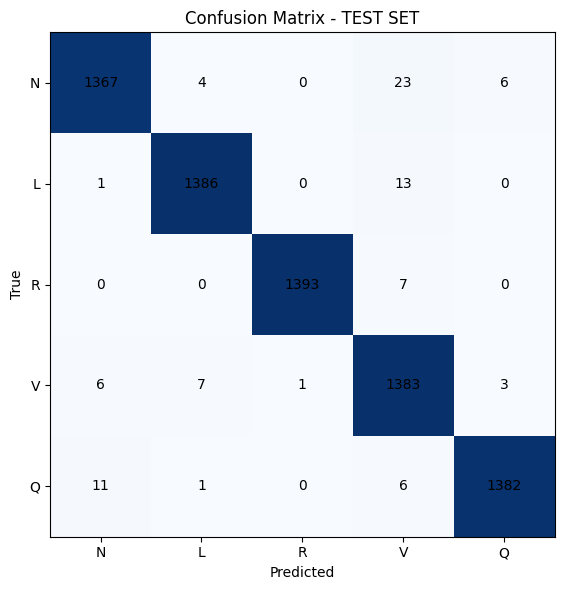


✅ Metrik disimpan di: D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_AKHIR_RECORD\BEATS\EVALUASI_BERT_3
   Accuracy  Recall  Specificity      F1
N    0.9927  0.9764       0.9968  0.9817
L    0.9963  0.9900       0.9979  0.9907
R    0.9989  0.9950       0.9998  0.9971
V    0.9906  0.9879       0.9912  0.9767
Q    0.9961  0.9871       0.9984  0.9903


In [1]:
import os, glob
import numpy as np, pandas as pd, torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# === KONFIGURASI ===
MODEL_BASE = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\HASIL_BERT\HASIL_5"
FOLD_NAME  = "fold2"  # << GANTI sesuai fold yang ingin kamu pakai
TEST_DIR   = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\DATA\output_coba\SPLIT_BEATS_NPY\Beats_TEST"
OUTPUT_EVAL_DIR = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_AKHIR_RECORD\BEATS\EVALUASI_BERT_3"
os.makedirs(OUTPUT_EVAL_DIR, exist_ok=True)

LABEL_MAP  = {'N':0, 'L':1, 'R':2, 'V':3, 'Q':4}
IDX2LABEL  = {v: k for k, v in LABEL_MAP.items()}
cls_names  = list(LABEL_MAP.keys())
MAX_LEN    = 512
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === UTILITAS ===
def signal_to_text(sig: np.ndarray) -> str:
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    return " ".join(map(str, norm.tolist()))

def load_test_data():
    files, labels = [], []
    for cls, idx in LABEL_MAP.items():
        folder_path = os.path.join(TEST_DIR, cls)
        if not os.path.exists(folder_path):
            print(f"[WARNING] Folder tidak ditemukan: {folder_path}")
            continue
        file_list = glob.glob(os.path.join(folder_path, "*.npy"))
        files.extend(file_list)
        labels.extend([idx] * len(file_list))
    return files, labels

# === LOAD MODEL DAN TOKENIZER ===
model_path = os.path.join(MODEL_BASE, FOLD_NAME)
print(f"[INFO] Loading model dari: {model_path}")
model = BertForSequenceClassification.from_pretrained(model_path).to(DEVICE)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.eval()

# === LOAD DATA TEST ===
test_files, test_labels = load_test_data()
print(f"[INFO] Jumlah data test: {len(test_files)}")

y_true, y_pred = [], []

for i, (file, label) in enumerate(zip(test_files, test_labels)):
    try:
        signal = np.load(file)
        txt = signal_to_text(signal)
        enc = tokenizer(txt, padding="max_length", truncation=True,
                        max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            output = model(**enc)
            pred = output.logits.argmax(dim=1).item()
        y_true.append(label)
        y_pred.append(pred)
    except Exception as e:
        print(f"[ERROR] Gagal memproses file {file}: {e}")

# === EVALUASI AKHIR ===
if len(y_true) == 0:
    print("[ERROR] Tidak ada data yang berhasil diprediksi.")
else:
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, labels=list(LABEL_MAP.values()), target_names=cls_names, digits=4))

    # CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred, labels=list(LABEL_MAP.values()))
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"Confusion Matrix - TEST SET")
    plt.xticks(range(len(cls_names)), cls_names)
    plt.yticks(range(len(cls_names)), cls_names)
    for r in range(len(cm)):
        for c in range(len(cm)):
            plt.text(c, r, cm[r, c], ha='center', va='center', color='black')
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(OUTPUT_EVAL_DIR, "confusion_matrix_test.png"))
    plt.close()

    # SIMPAN METRIK PER KELAS
    df_metrics = pd.DataFrame(columns=["Accuracy", "Recall", "Specificity", "F1"])
    for i, cls in enumerate(cls_names):
        TP = cm[i, i]
        FN = cm[i].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        acc  = (TP + TN) / cm.sum()
        rec  = TP / (TP + FN + 1e-8)
        spec = TN / (TN + FP + 1e-8)
        f1   = f1_score(np.array(y_true) == i, np.array(y_pred) == i)
        df_metrics.loc[cls] = [acc, rec, spec, f1]

    df_metrics = df_metrics.round(4)
    df_metrics.to_csv(os.path.join(OUTPUT_EVAL_DIR, "test_metrics.csv"))
    print(f"\n✅ Metrik disimpan di: {OUTPUT_EVAL_DIR}")
    print(df_metrics)

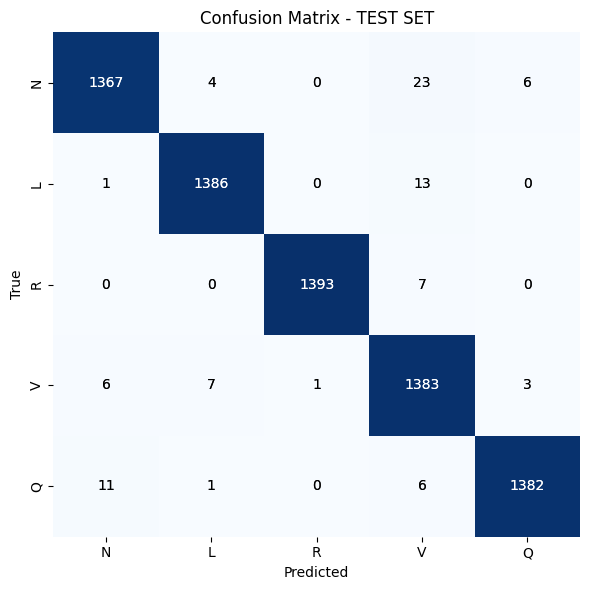

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Contoh data CM Anda (sama seperti gambar)
cm = np.array([
    [1367, 4, 0, 23, 6],
    [1, 1386, 0, 13, 0],
    [0, 0, 1393, 7, 0],
    [6, 7, 1, 1383, 3],
    [11, 1, 0, 6, 1382]
])

labels = ['N', 'L', 'R', 'V', 'Q']

plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

# Mengatur warna teks berdasarkan posisi diagonal (putih) vs lainnya (hitam)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if i == j else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center',
                color=text_color,
                fontsize=10)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TEST SET")
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# === PATH FILE EXCEL ===
beats_path  = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\hasil_Bert_beats.xlsx"
rythm_path  = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\hasil_Bert_rythm (1).xlsx"

# === BACA DATA ===
beats_df = pd.read_excel(beats_path)
rythm_df = pd.read_excel(rythm_path)

# === GRAFIK BEATS ===
plt.figure(figsize=(8, 5))
plt.plot(beats_df["Epoch"], beats_df["Training Loss"], marker='o', label="Train Loss", color='blue')
plt.plot(beats_df["Epoch"], beats_df["Validation Loss"], marker='o', label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss - BERT (Beats)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\grafik_loss_bert_beats.png", dpi=300)
plt.close()

# === GRAFIK RYTHM ===
plt.figure(figsize=(8, 5))
plt.plot(rythm_df["Epoch"], rythm_df["Training Loss"], marker='o', label="Train Loss", color='green')
plt.plot(rythm_df["Epoch"], rythm_df["Validation Loss"], marker='o', label="Validation Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss - BERT (Rhythm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\grafik_loss_bert_rythm.png", dpi=300)
plt.close()